In [1]:
import tensorflow as tf
import numpy as np
import os
import scipy.signal as signal
from skimage.measure import block_reduce

import tensorflow as tf
import numpy as np

def load_mnist_data():
    # Загружаем MNIST с использованием TensorFlow
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

    # Добавляем дополнительную размерность для канала (1) и нормализуем данные
    train_images = np.expand_dims(train_images, axis=1).astype(np.float32) / 255.0
    test_images = np.expand_dims(test_images, axis=1).astype(np.float32) / 255.0

    return train_images, train_labels, test_images, test_labels

# Загрузка данных
train_images, train_labels, test_images, test_labels = load_mnist_data()

# Проверим формы данных
print("Train images shape:", train_images.shape)  # (60000, 1, 28, 28)
print("Test images shape:", test_images.shape) 

2025-05-13 10:41:36.821527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747132897.022931      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747132897.083066      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train images shape: (60000, 1, 28, 28)
Test images shape: (10000, 1, 28, 28)


In [2]:
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        self.output = None
        self.input = None
        self.bias = np.zeros(out_channels, dtype=np.float32)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.kernels = np.random.randn(out_channels,in_channels, kernel_size, kernel_size).astype(np.float32)*0.1
    def forward(self, x):
        self.input = x
        batch_size, in_ch, in_height, in_width = x.shape
        out_h = in_height - self.kernel_size + 1 + 2 * self.padding
        out_w = in_width - self.kernel_size + 1 + 2 * self.padding

        out = np.zeros((batch_size, self.out_channels, out_h , out_w))

        k_size, out_ch, pd = self.kernel_size,self.out_channels, self.padding
        

        if pd > 0:
            x_padded = np.pad(x, ((0, 0), (0, 0), (pd, pd), (pd, pd)), mode='constant')
        else:
            x_padded = x

        for b in range(batch_size):
            for i in range(out_ch):
                out[b, i] = np.copy(self.bias[i])
                for j in range(in_ch):
                    out[b,i] += signal.correlate2d(x_padded[b,j], self.kernels[i,j],"valid")
        self.output = out
        return self.output

    def backward(self, out_grad, learning_rate):
        kernels_grad = np.zeros_like(self.kernels)
        batch_size = out_grad.shape[0]

        pad = self.padding
        if pad > 0:
            x_padded = np.pad(self.input,
                              ((0,0), (0,0), (pad,pad), (pad,pad)),
                              mode='constant')
        else:
            x_padded = self.input
        input_grad = np.zeros_like(x_padded)

        for b in range (batch_size):
            for i in range(self.out_channels):
                for j in range(self.in_channels):
                    kernels_grad[i,j] += signal.correlate2d(self.input[b,j], out_grad[b,i],"valid")
                    input_grad[b, j] += signal.convolve2d(out_grad[b,i], self.kernels[i,j],"full")

        self.kernels -= learning_rate * kernels_grad / batch_size
        self.bias -= learning_rate * np.sum(out_grad, axis=(0,2,3)) / batch_size
        if pad > 0:
            return input_grad[:,:, pad:-pad, pad:-pad]
        else:
            return input_grad

class AvgPool2d:
    def __init__(self, kernel_size,stride):
        self.input = None
        self.kernel_size = kernel_size
        self.stride = stride
        self.output = None

    def forward(self, x):
        self.input = x
        batch_size, in_ch, h, w = x.shape
        k_size = self.kernel_size
        self.output = np.zeros((batch_size, in_ch, h // k_size, w // k_size))

        for b in range(batch_size):
            for i in range(in_ch):
                self.output[b,i] += block_reduce(x[b,i],(k_size,k_size), np.mean)
        return self.output

    def backward(self, out_grad):
        batch_size, channels,_,_ = self.input.shape
        input_grad = np.zeros_like(self.input)

        for b in range(batch_size):
            for i in range(channels):
                extend_out = np.repeat(np.repeat(out_grad[b,i],self.stride,axis=0), self.stride, axis=1)
                input_grad[b,i] += extend_out / (self.kernel_size * self.kernel_size)
        return input_grad

class Linear:
    def __init__(self, in_features, out_features):
        self.input = None
        self.output = None
        self.in_features = in_features
        self.out_features = out_features
        self.weights = np.random.randn(in_features, out_features).astype(np.float32)*0.1
        self.bias = np.zeros(out_features, dtype=np.float32)

    def forward(self, x):
        self.input = x
        self.output = x.dot(self.weights)
        return self.output + self.bias

    def backward(self, grad_output, learning_rate):
        grad_input = grad_output.dot(self.weights.T)
        grad_weights = self.input.T.dot(grad_output)
        batch_size = grad_output.shape[0]
        grad_bias = np.sum(grad_output, axis=0)

        self.weights -= learning_rate * grad_weights / batch_size
        self.bias    -= lr * grad_bias / batch_size
        return grad_input
class Flatten:
    def __init__(self):
        self.input_shape = None

    def forward(self, x):
        self.input_shape = x.shape
        return x.reshape(x.shape[0],-1)

    def backward(self, grad, _):
        return grad.reshape(self.input_shape)

In [3]:
def tanh(x):
    return np.tanh(x)
def tanh_deriv(x):
    # Здесь x — это уже tanh(z)
    return 1 - tanh(x)**2

def softmax(x):
    x_shifted = x - np.max(x, axis=1, keepdims=True)
    e = np.exp(x_shifted)
    return e / np.sum(e, axis=1, keepdims=True)


def cross_entropy(y_true, probs):
    return -np.mean(np.sum(y_true * np.log(probs), axis=1))

def cross_entropy_deriv(y_true, probs):
    return (probs - y_true) / y_true.shape[0]

def to_one_hot(y, num_classes):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

In [4]:
class LeNet5:
    def __init__(self):
        self.conv1 = Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool1 = AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = AvgPool2d(kernel_size=2, stride=2)
        self.flatten = Flatten()
        self.fc1 = Linear(16 * 5 * 5, 120)
        self.fc2 = Linear(120, 84)
        self.fc3 = Linear(84, 10)
    def forward(self, x):
        x = tanh(self.conv1.forward(x))
        x = tanh(self.pool1.forward(x))
        x = tanh(self.conv2.forward(x))
        x = tanh(self.pool2.forward(x))
        x = self.flatten.forward(x)
        x = tanh(self.fc1.forward(x))
        x = tanh(self.fc2.forward(x))
        x = softmax(self.fc3.forward(x))
        return x
    def backward(self, grad, lr):
        grad = self.fc3.backward(grad, lr)
        grad = tanh_deriv(self.fc2.output) * grad
        grad = self.fc2.backward(grad, lr)
        grad = tanh_deriv(self.fc1.output) * grad
        grad = self.fc1.backward(grad, lr)
        grad = self.flatten.backward(grad, lr)
        grad = self.pool2.backward(grad)
        grad = tanh_deriv(self.conv2.output) * grad
        grad = self.conv2.backward(grad, lr)
        grad = self.pool1.backward(grad)
        grad = tanh_deriv(self.conv1.output) * grad
        grad = self.conv1.backward(grad, lr)

In [5]:
train_losses = []
train_accuracies = []
epochs = 15
model = LeNet5()
batch_size=64
lr=0.5
epoch_loss = 0.0

num_classes = 10

one_hot_labels = to_one_hot(train_labels, 10)

for epoch in range(epochs):
    indices = np.random.permutation(len(train_images))
    X_shuffled, Y_shuffled, one_hot_Y = train_images[indices], train_labels[indices], one_hot_labels[indices]
    loss = 0.0
    correct = 0.0
    running_loss = 0.0

    for i in range(0, len(X_shuffled), batch_size):
        x_batch = X_shuffled[i:i+batch_size]
        y_batch = Y_shuffled[i:i+batch_size]
        one_hot_batch = one_hot_Y[i:i+batch_size]

        logits = model.forward(x_batch)
        preds = np.argmax(logits, axis=1)
        correct += np.sum(preds == y_batch)

        loss = cross_entropy(one_hot_batch, logits)
        running_loss +=loss * len(x_batch)
        grad = cross_entropy_deriv(one_hot_batch, logits)
        model.backward(grad, lr)

    epoch_loss = running_loss / len(X_shuffled)
    train_losses.append(epoch_loss)
    acc = correct / len(X_shuffled)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {acc*100:.2f}%")

Epoch 1, Loss: 1.0711, Accuracy: 72.23%
Epoch 2, Loss: 0.4563, Accuracy: 87.46%
Epoch 3, Loss: 0.3579, Accuracy: 89.63%
Epoch 4, Loss: 0.3082, Accuracy: 90.91%
Epoch 5, Loss: 0.2734, Accuracy: 91.88%
Epoch 6, Loss: 0.2464, Accuracy: 92.70%
Epoch 7, Loss: 0.2244, Accuracy: 93.33%
Epoch 8, Loss: 0.2058, Accuracy: 93.91%
Epoch 9, Loss: 0.1900, Accuracy: 94.38%
Epoch 10, Loss: 0.1764, Accuracy: 94.81%
Epoch 11, Loss: 0.1648, Accuracy: 95.14%
Epoch 12, Loss: 0.1547, Accuracy: 95.44%
Epoch 13, Loss: 0.1457, Accuracy: 95.65%
Epoch 14, Loss: 0.1380, Accuracy: 95.86%
Epoch 15, Loss: 0.1308, Accuracy: 96.08%


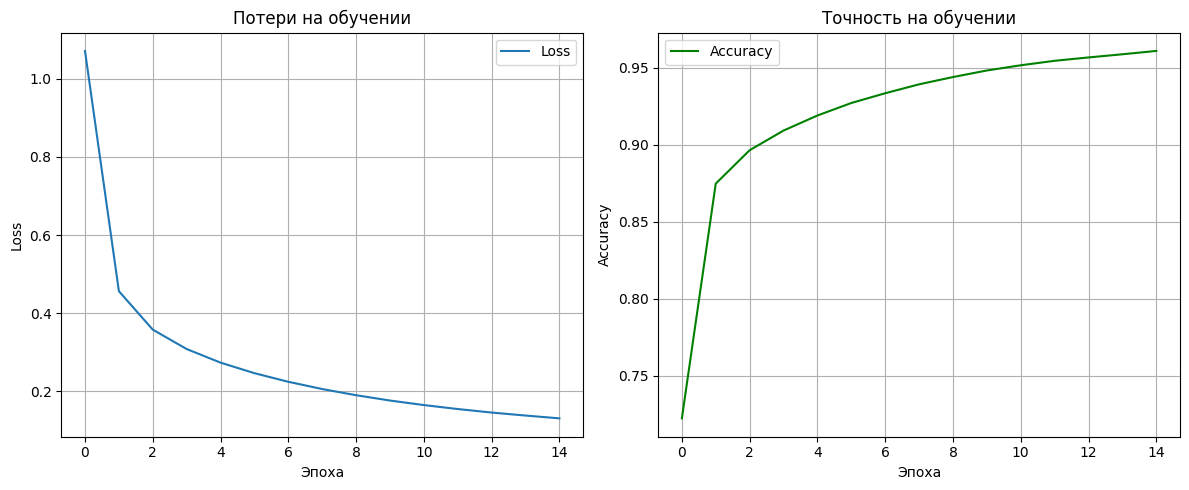

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.title("Потери на обучении")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Accuracy", color='green')
plt.title("Точность на обучении")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Точность на тестовых данных: 96.14%


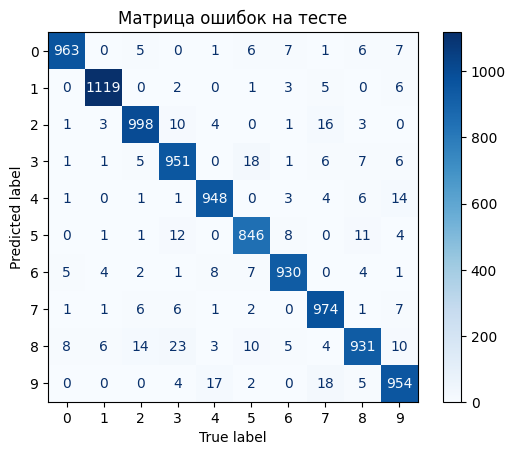

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

N = test_images.shape[0]
predictions = []

for i in range(0, N, batch_size):
    x_batch = test_images[i : i + batch_size]              # (b, C, H, W)
    logits = model.forward(x_batch) # → (b, num_classes)
    # если у вас spatial-выход, то:
    # logits = logits.mean(axis=(2, 3))                     # теперь (b, num_classes)
    preds = np.argmax(logits, axis=1)                       # (b,)
    predictions.append(preds)

# flatten
predictions = np.concatenate(predictions)  # (N,)

# accuracy
acc = np.mean(predictions == test_labels)
print(f'Точность на тестовых данных: {acc * 100:.2f}%')

# confusion matrix
cm = confusion_matrix(predictions, test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.arange(num_classes))
disp.plot(cmap='Blues')
plt.title("Матрица ошибок на тесте")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
